In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

In [9]:
path = r'C:\Users\jschu\Downloads\ISIC_Files'
os.chdir(path)

In [10]:
image_values_df = pd.read_csv('C:/Users/jschu/Downloads/ISIC_Files/ISIC_2019_Training_GroundTruth.csv')
image_values_df["type"] = image_values_df[["MEL", "NV", "BCC", "AK", "BKL", "DF", "SCC", "VASC"]].idxmax(axis=1)
image_values_df = image_values_df[['image', 'type']]
print("Number of rows in Image data set before Merge:", len(image_values_df))
metadata_df = pd.read_csv('C:/Users/jschu/Downloads/ISIC_Files/ISIC_2019_Training_Metadata.csv')
print("Number of rows in Metadata data set before Merge:", len(metadata_df))
image_values_df = image_values_df.merge(metadata_df, on = 'image', how = 'inner')
print("Number of rows in Merged Dataset:", len(image_values_df))


Number of rows in Image data set before Merge: 25331
Number of rows in Metadata data set before Merge: 25331
Number of rows in Merged Dataset: 25331


In [11]:
labels_df = image_values_df

Sample of images in data:


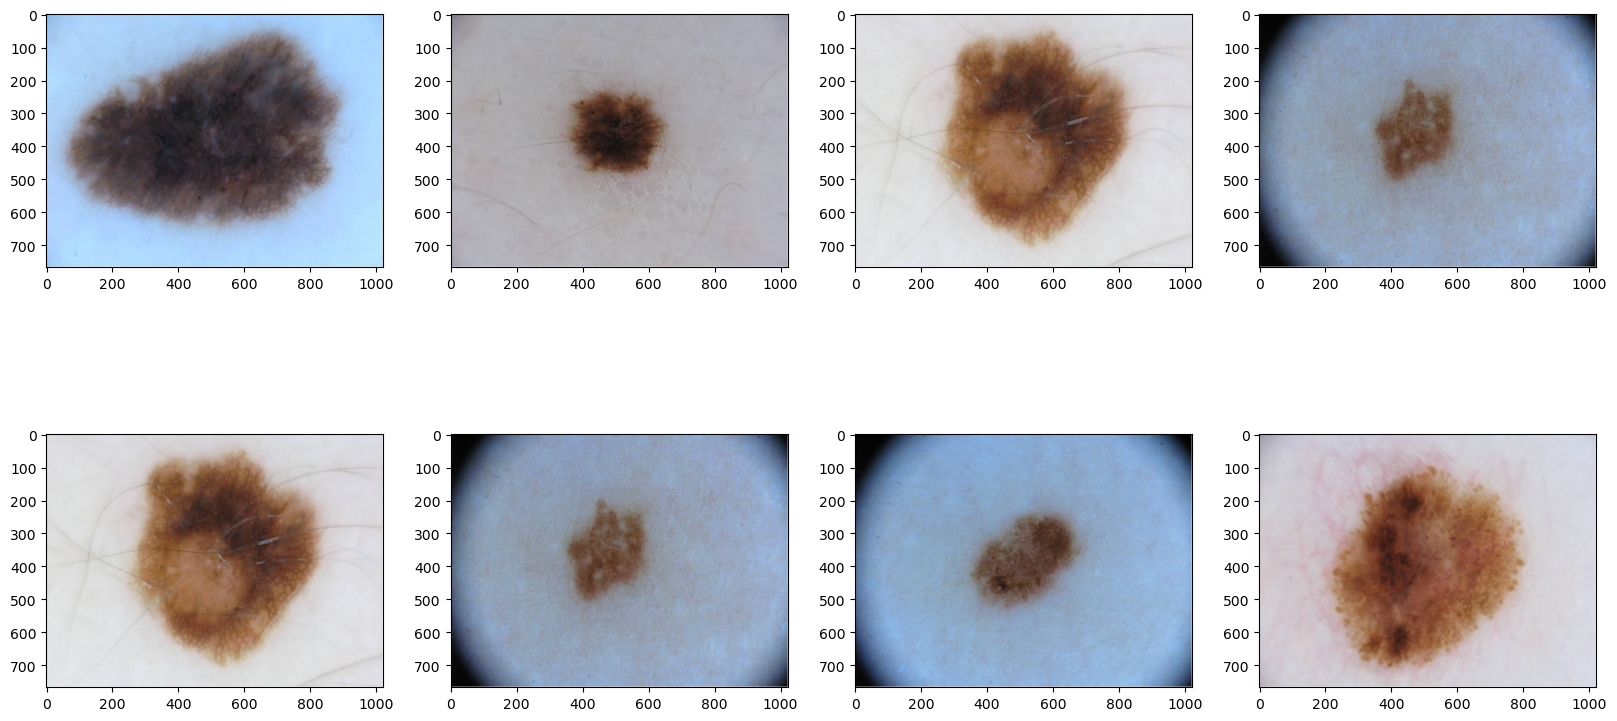

In [12]:
# read image
indx=0
images = []

IMAGE_PATH = r'C:\Users\jschu\Downloads\ISIC_Files/Images/' 

print('Sample of images in data:')
for folder in labels_df['type'].unique():
    for idx, img in enumerate(os.listdir(IMAGE_PATH + folder + '/')):
        img = load_img(
        IMAGE_PATH + folder + '/' + img)
        images.append(img)

nrows, ncols = 2,4 #print first 8 images
f, axs = plt.subplots(nrows, ncols, figsize=(20,10))
for i in range(nrows):
    for j in range(ncols):
        indx = i*nrows+j
        axs[i,j].imshow(images[indx])

NV: 12875
MEL: 4522
BCC: 3323
BKL: 2624
AK: 867
SCC: 628
VASC: 253
DF: 239
Proportion of examples in NV Class: 50.83%


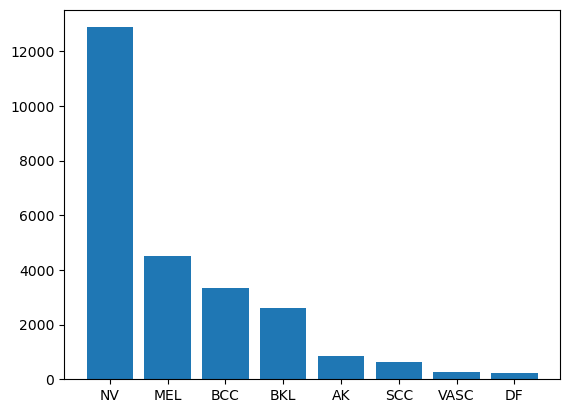

In [13]:
plt.bar(x = labels_df['type'].value_counts().index, height = labels_df['type'].value_counts())
for i in labels_df['type'].value_counts().index:
    print(i, ": ", labels_df['type'].value_counts()[i], sep = '')  
print("Proportion of examples in NV Class: ", 
      round(labels_df['type'].value_counts()['NV'] / len(labels_df)*100, 2), '%', sep = '')

In [23]:
#Replace the Y as either Melanoma or Non-Melanoma
np.random.seed(1234)

NOMEL = labels_df[labels_df['type'] != 'MEL']
MEL = labels_df[labels_df['type'] == 'MEL']


# randomly draw images from Non-MEL Class
temp_NOMEL = []
temp_MEL = []

size = int(len(MEL)/4)

temp_NOMEL = list(np.random.choice(
    NOMEL.image,
    size=size,
    replace=False
))

temp_MEL = list(np.random.choice(
    MEL.image,
    size=size,
    replace=False
))


In [24]:
def preprocess_data_part1(IMAGE_PATH,temp_NOMEL, temp_MEL):
    """ Generate lists of images and labelsbased on temp_NOMEL or temp_MEL
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    LABEL_PATH (str): path to directory with labels.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 300, 225, 3)
    y_mini (np.ndarray): Labels of shape (N,)    
    """
    y_mini = []
    images_mini = []
    count = 0
    # create lists of images and labels `images_mini` and `y_mini` 
    # based on temp tables created above for each diagnoses class
    for folder in labels_df['type'].unique():
        for idx, img in enumerate(os.listdir(IMAGE_PATH + folder + '/')):
            count+=1
            # read labels
            if img.split('.')[0] in temp_NOMEL:
                    y_mini.append(0)
            elif img.split('.')[0] in temp_MEL:
                    y_mini.append(1)
            else:
                continue

        
            # read image
            img = load_img(
                IMAGE_PATH + folder +'/'+ img,
                target_size=(300, 225)
            )

            # transform image to array
            img = img_to_array(img)

            # append to images
            images_mini.append(img)
            count+=1
        print(count)
    
    # stack images and transform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten() 
    
    return images_mini, y_mini

In [25]:
# generate images and labels based on preprocess_data_part1() function
images_mini, y_mini = preprocess_data_part1(IMAGE_PATH,temp_NOMEL, temp_MEL)

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")
sum(y_mini)

13573
19225
21988
22243
22899
26408
26676
27591
images_mini shape (2260, 300, 225, 3)
y_mini shape (2260,)


1130

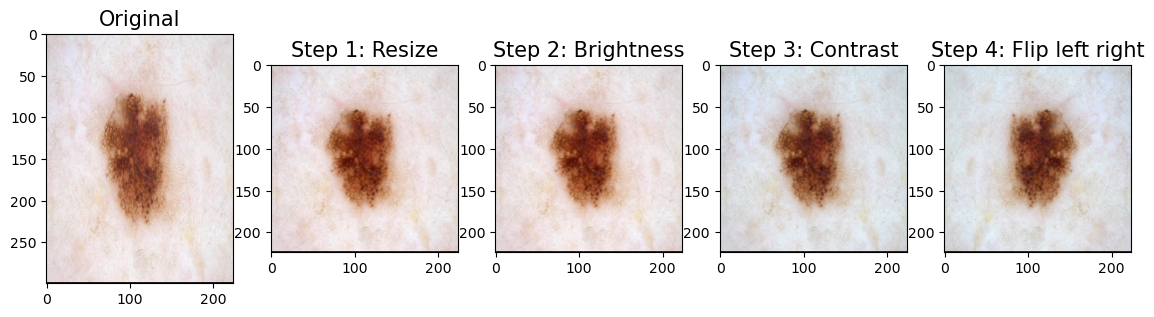

In [26]:
tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = images_mini[0]

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);

# resize
ax = fig.add_subplot(1, 5, 2)
img_resize = tf.image.resize(image, size=(224, 224))
ax.imshow(array_to_img(img_resize))
ax.set_title('Step 1: Resize', size=15);


# adjust brightness
ax = fig.add_subplot(1, 5, 3)
img_bright = tf.image.adjust_brightness(img_resize, 0.3)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 5, 4)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 5, 5)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);

In [27]:
IMAGE_SIZE = (300, 225)
CONTRAST_FACTOR = 3
DELTA = 0.3

def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 300, 225, 3)
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 300, 225, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 300, 225, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 300, 225, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]
    
    splits = np.multiply(len(images_mini), split).astype(int)
    X_train, X_val, X_test = np.split(images_mini, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y_mini, [splits[0], splits[0]+splits[1]])
    
    ### image transformation on training, validation, and test data ###
    ###################################################################
    # image resize
    X_train = tf.image.resize(X_train, size=IMAGE_SIZE)
    X_val = tf.image.resize(X_val, size=IMAGE_SIZE)
    X_test = tf.image.resize(X_test, size=IMAGE_SIZE)
    
    # rescale image to [0,1], i.e., greyscale
    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0
    
    """
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)
    
    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    """
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [28]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (1356, 300, 225, 3)
y_train shape (1356,)
X_val shape (452, 300, 225, 3)
y_val shape (452,)
X_test shape (452, 300, 225, 3)
y_test shape (452,)


# Melanoma Only Analysis

In [29]:
model = tf.keras.Sequential()

# add first convolution layer to the model
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)


# add a fully connected layer (need to flatten the output of the previous layers first)
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# add dropout layer
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
# this last layer sets the activation function to "None" in order to output the logits 
# note that passing activation = "sigmoid" will return class memembership probabilities but
# in TensorFlow logits are prefered for numerical stability
# set units=1 to get a single output unit (remember it's a binary classification problem)
model.add(tf.keras.layers.Dense(
    units=1,
    name='fc_2',
    activation=None))


# build model and print summary
tf.random.set_seed(1)
model.build(input_shape=(None, 300, 225, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 300, 225, 32)      2432      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 150, 112, 32)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 150, 112, 64)      51264     
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 75, 56, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 268800)            0         
_________________________________________________________________
fc_1 (Dense)                 (None, 1024)              275252224 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)             

In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
              metrics=['accuracy']) 

In [31]:
# set random seed to get reproductible results 
# neural network algorithms are stochastic (e.g., due to random weight initialization); setting a random seed helps to get more stable results after each run
# however, best way to deal with randomness is to repeat your experiment many times (30+) and use statistics to summarize the performance of the model
tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(X_train, y_train,
                    epochs=10, 
                    validation_data=(X_val, y_val)
)

Epoch 1/10
43/43 [==============================] - 118s 3s/step - loss: 2.0688 - accuracy: 0.5147 - val_loss: 0.6897 - val_accuracy: 0.0000e+00
Epoch 2/10
43/43 [==============================] - 120s 3s/step - loss: 0.6908 - accuracy: 0.5324 - val_loss: 0.5643 - val_accuracy: 0.3319
Epoch 3/10
43/43 [==============================] - 136s 3s/step - loss: 0.6849 - accuracy: 0.5332 - val_loss: 0.6404 - val_accuracy: 0.1770
Epoch 4/10
43/43 [==============================] - 141s 3s/step - loss: 0.7202 - accuracy: 0.5280 - val_loss: 0.6168 - val_accuracy: 0.3009
Epoch 5/10
43/43 [==============================] - 126s 3s/step - loss: 0.6797 - accuracy: 0.5420 - val_loss: 0.6004 - val_accuracy: 0.3186
Epoch 6/10
43/43 [==============================] - 126s 3s/step - loss: 0.6869 - accuracy: 0.5413 - val_loss: 0.7389 - val_accuracy: 0.0000e+00
Epoch 7/10
43/43 [==============================] - 124s 3s/step - loss: 0.6862 - accuracy: 0.5214 - val_loss: 0.6489 - val_accuracy: 0.2146
Epoch

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()